In [1]:
from pathlib import Path
from itertools import combinations

import pandas as pd
pd.set_option("display.max_columns", None)
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from numpy import nan
from scipy.stats import chi2_contingency, kruskal

In [2]:
#DATA_DIR = Path.cwd().resolve().parents[1]

In [3]:
df = pd.read_parquet("data/01_raw/movies_dataset_2025-05-07.parquet")

In [4]:
cat_cols = ["original_language", "source", "status"]
df[cat_cols] = df[cat_cols].astype("category")

In [5]:
df.sample(5)

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count,source,entry_date,was_ingested,is_popular,runtime,budget,revenue,status,tagline,genres,spoken_languages,keywords
2692,False,/jKZaTlLM3ulKInSKcZxrGfOQyg.jpg,[99],1157419,fr,Madame Hofmann,"""Welcome to my life"", Sylvie Hofmann repeats t...",0.1675,/rX03DtKD0LiV3DkwCrzz7goAz4b.jpg,2024-04-10,Madame Hofmann,False,6.500,15,exploratory,2025-03-16,False,False,104,0,0,Released,,[Documental],[Français],"[nurse, marseille, france, retirement, hospita..."
165,False,/tehewlwOPFDDf4syutyopaY23AY.jpg,[27],1352774,en,Piglet,"On Kate's 21st birthday camping trip, her frie...",13.0888,/5wZNFUJAwyX6RCxdqrLO9lLWJ20.jpg,2025-01-25,Piglet,False,5.735,17,exploratory,2025-04-27,False,False,83,0,0,Released,,[Terror],[English],"[serial killer, human animal hybrid, teen slas..."
2305,False,/46wPEQ5D8zQWqz1bzAzpXNIkETA.jpg,[18],964258,no,Sulis 1907,"In 1907, the miners in Sulitjelma in Fauske in...",0.5268,/rLbFl9JdtAuaC66hljn2GYh71Kj.jpg,2023-10-06,The Riot,False,6.900,14,exploratory,2025-03-23,False,False,105,0,0,Released,,[Drama],"[, Norsk, svenska]","[rebellion, norway, uprising, mining town, wor..."
4286,False,/m7xifwtBHlKuEVqBNFafJHwF6RQ.jpg,"[10752, 28, 12, 53]",964426,no,Gulltransporten,"Fredrik isn’t the bravest of men, but now he i...",1.5160,/6E4LopmCMUXcMLIv7o3jw1xQrgJ.jpg,2022-12-15,Gold Run,False,6.524,126,exploratory,2025-01-25,False,False,117,0,0,Released,,"[Bélica, Acción, Aventura, Suspense]","[Norsk, Deutsch]","[world war ii, stealing, gold shipment, stolen..."
2217,False,/A9loTajiNEApXPRIvCme7nViT0K.jpg,"[10770, 35, 10749]",1175674,en,Coupled Up for Christmas,This was supposed to be the Christmas Tiffany ...,0.2512,/p3uZr6keOKa3P5iRdIHeozactwi.jpg,2023-10-18,Coupled Up for Christmas,False,7.100,28,exploratory,2025-01-22,False,False,90,0,0,Released,,"[Película de TV, Comedia, Romance]",[English],"[holiday, christmas]"


In [6]:
df["video"].value_counts()

,count
video,
False,8000


In [7]:
df["adult"].value_counts()

,count
adult,
False,8000


In [8]:
df["source"].value_counts()

,count
source,
exploratory,8000


In [9]:
df["was_ingested"].value_counts()

,count
was_ingested,
False,8000


In [10]:
df["status"].value_counts()

,count
status,
Released,8000


# Some conclusions from a first glance
- `overview` and `tagline` columns would be hard to analyze and feed to the model, due to it's free text nature. This column will bring low to none value with this initial state, however NLP technices like NER could be applied to the text in order of extracting 'mentioned entities'. For now this column won't be taken into account for the analysis.   
- Id columns like: `genre_ids` and `id` won't be taken into account either.
- `original_title`, `title` and `poster_path` columns won't be taken.
- `source`, `adult`, `was_ingested`, `status` and `video` columns will be discarded too as they present a constant behaviour.

In [11]:
analyze_cols: list[str] = ['original_language', 'popularity', 'release_date', 'vote_average',
       'vote_count', 'entry_date', 'is_popular', 'runtime', 'budget',
       'revenue', 'genres', 'spoken_languages', 'keywords']

df = df[analyze_cols]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_language  8000 non-null   category      
 1   popularity         8000 non-null   float64       
 2   release_date       8000 non-null   object        
 3   vote_average       8000 non-null   float64       
 4   vote_count         8000 non-null   int64         
 5   entry_date         8000 non-null   datetime64[ns]
 6   is_popular         8000 non-null   bool          
 7   runtime            8000 non-null   int64         
 8   budget             8000 non-null   int64         
 9   revenue            8000 non-null   int64         
 10  genres             8000 non-null   object        
 11  spoken_languages   8000 non-null   object        
 12  keywords           8000 non-null   object        
dtypes: bool(1), category(1), datetime64[ns](1), float64(2), int64(4

# Numerical vs. numerical

In [13]:
num_cols: list[str] = ['popularity', 'vote_average','vote_count', 'runtime', 'budget','revenue']

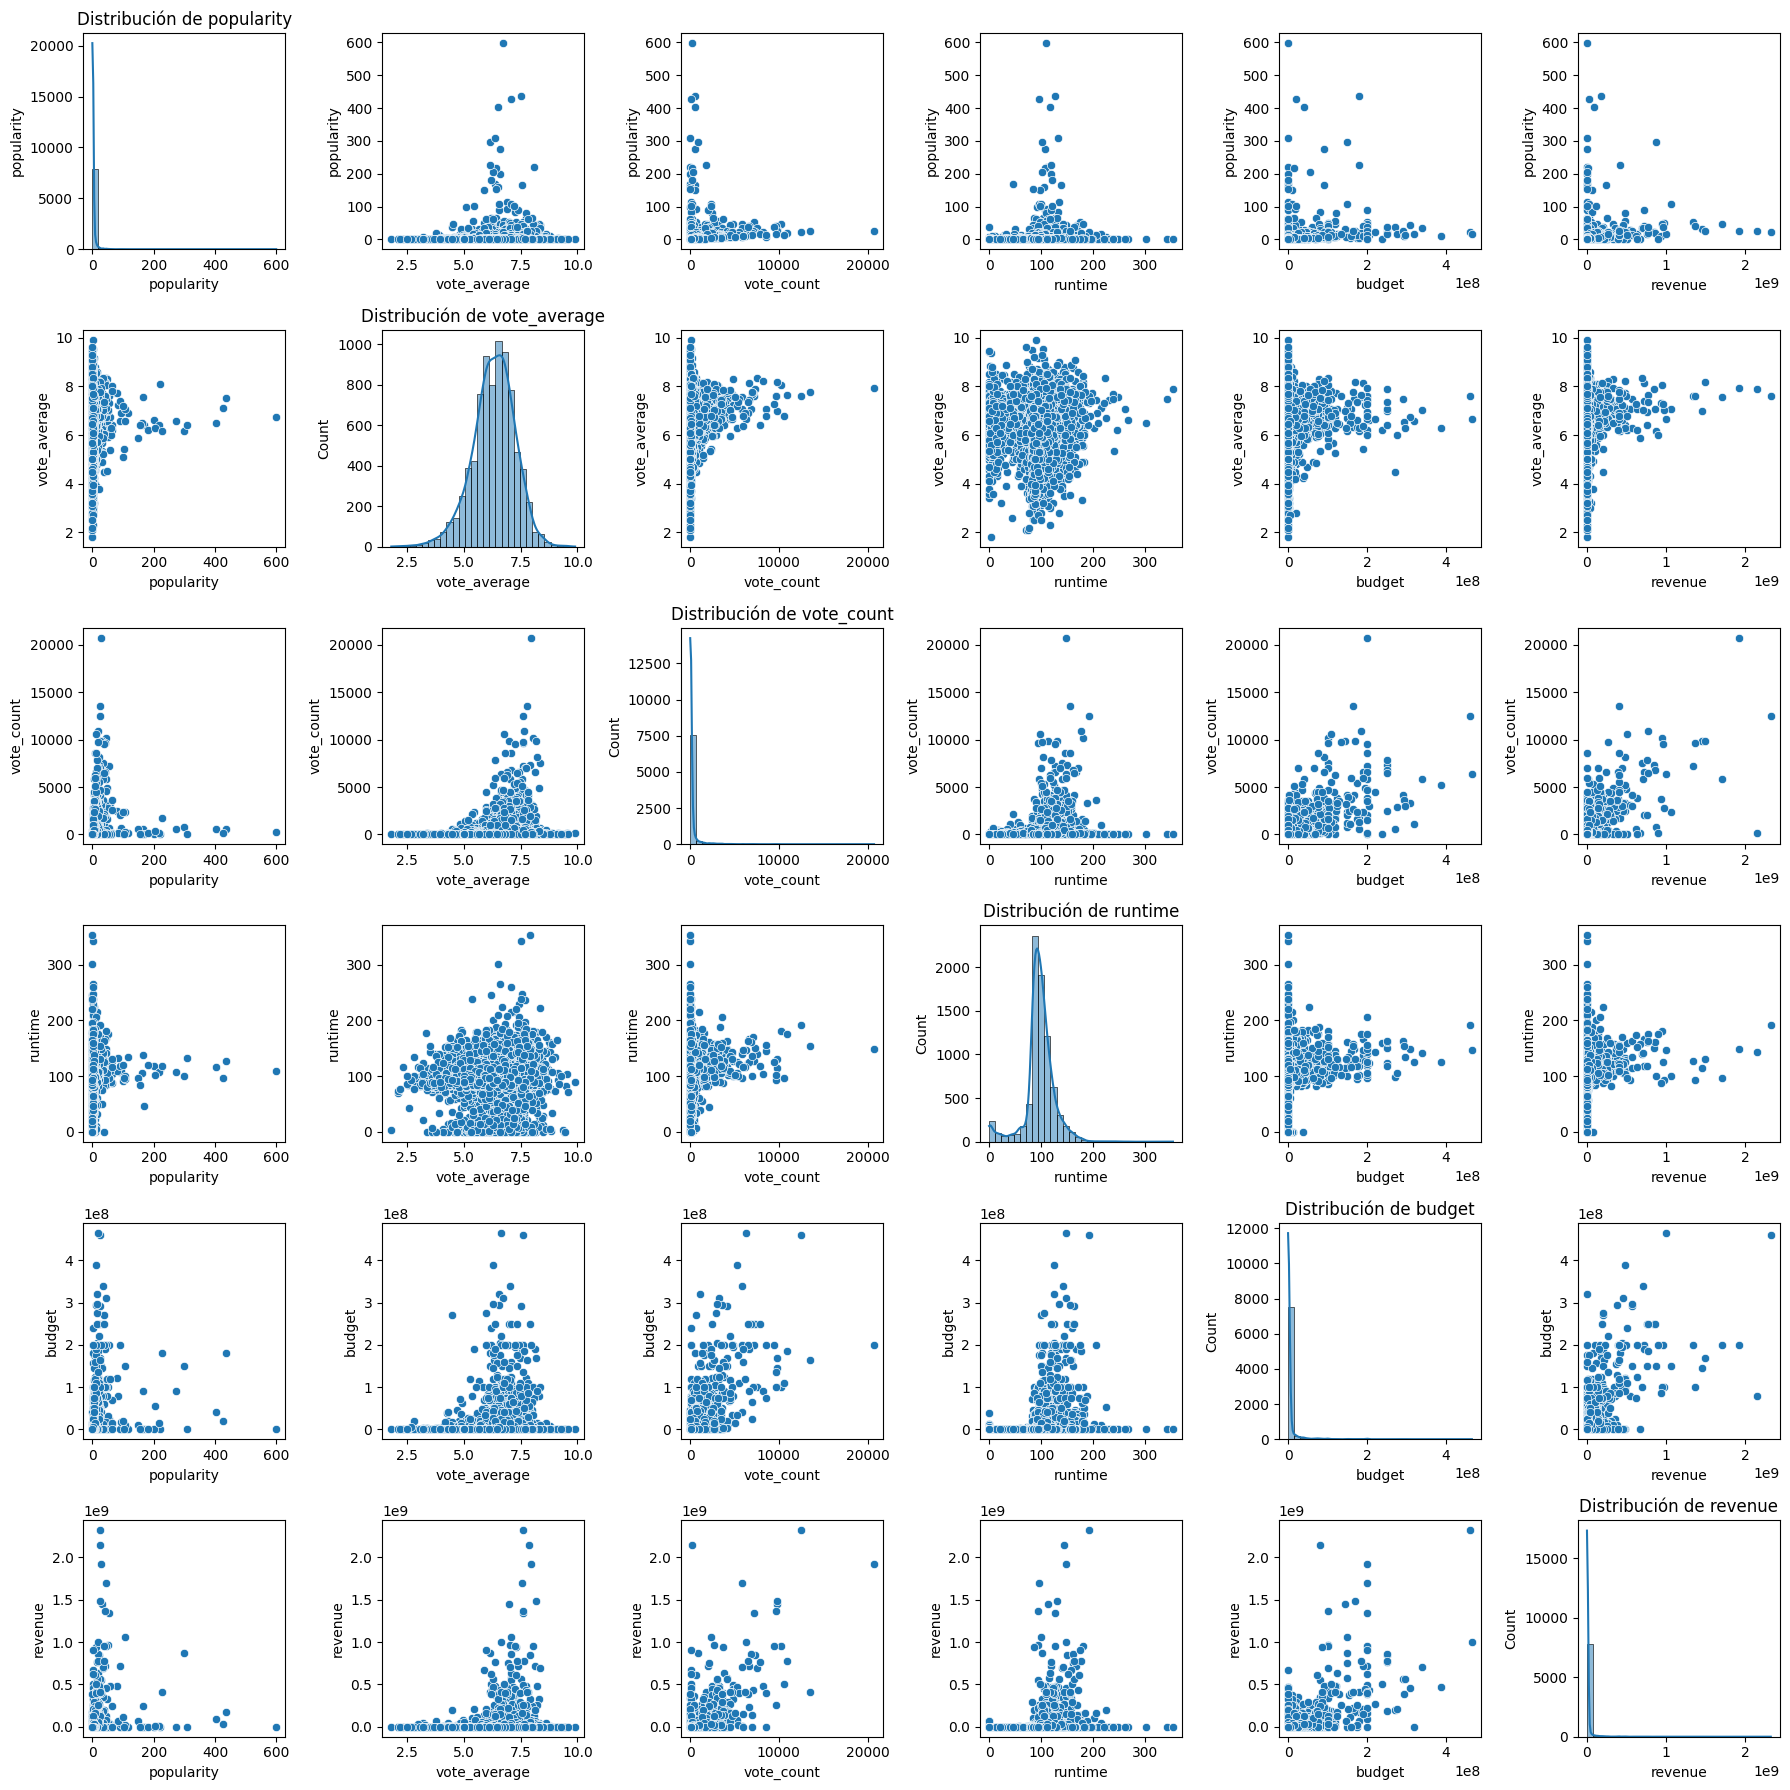

In [14]:
num_vars = len(num_cols)
fig, axes = plt.subplots(nrows=num_vars, ncols=num_vars, figsize=(3 * num_vars, 3 * num_vars))

for i, col1 in enumerate(num_cols):
    for j, col2 in enumerate(num_cols):
        ax = axes[i, j]
        if i == j:
            sns.histplot(df[col1], bins=30, kde=True, ax=ax)
            ax.set_title(f"Distribución de {col1}")
        else:
            sns.scatterplot(x=df[col2], y=df[col1], ax=ax)

        if j == 0:
            ax.set_ylabel(col1)
        if i == num_vars - 1:
            ax.set_xlabel(col2)
plt.tight_layout()
plt.show()

## Some findings
1. There seemes to be correlations present with `vote_count - revenue`, `budget - revenue` and `vote_count - budget`. This could imply a multicollinearity problem.
2. `vote_average` and `runtime` present a correlation as well, though much weaker as the mentioned above.  

In [15]:
multicol_cols: list[str] = ["vote_count", "revenue", "budget"]
multicol_vars = df[multicol_cols]
multicol_vars = add_constant(multicol_vars)
vif = DataFrame()

vif["feature"] = multicol_vars.columns
vif["VIF"] = [
    variance_inflation_factor(multicol_vars.values, i)
    for i in range(multicol_vars.shape[1])
]

In [16]:
vif

,feature,VIF
0,const,1.081031
1,vote_count,2.217110
2,revenue,2.194361
3,budget,2.241744


## Some findings
1. Features do present some level of correlation, however due to they are in the [1, 4) VIF range it's typically not considered severe enough to cause major issues in model estimation or interpretation.

<Axes: >

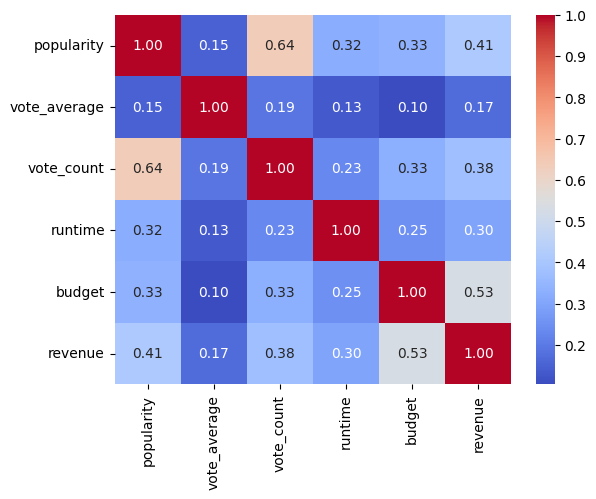

In [17]:
corr_matrix = df[num_cols].corr(method='spearman')  # spearman is chosen do to it's "tolerance" to outliers and measurement of non-linear relationships too.
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

## Some findings
1. The most outstanding result is the relation between `vote_count` and `popularity`, the most popular movies are the ones voted the most.
2. `budget` and `revenue` have a relationship as well, indicating that movies with more budget tend to receive more revenue.
3. Finally, `revenue` and `popularity` present a connection, implying that movies that are more popular tend to receive more revenue.

# Categorical vs. categorical

## Preprocessing
I'll preprocess the data a bit before for the analysis sake.

Due to the variety of languages present in the data I'll group them in 10 different languages clusters.
- European (Romance): Includes languages like French, Spanish, Italian, Portuguese, Catalan, and Romanian.
- European (Germanic): Includes English, German, Dutch, Norwegian, Danish, Swedish, Icelandic, and Afrikaans.
- European (Slavic): Includes Russian, Bulgarian, Polish, Ukrainian, Croatian, Slovak, Czech, Serbian, and Slovenian.
- European (Other): A grouping for other European languages that don't fit neatly into the main Romance, Germanic, or Slavic groups (e.g., Finnish, Lithuanian, Latvian, Georgian, Basque, Irish, Greek, Albanian).
- South Asian: Includes languages from the Indian subcontinent (e.g., Hindi, Tamil, Telugu, Urdu, Punjabi, Bengali, Sinhala).
- East Asian: Includes languages from East Asia (e.g., Cantonese, Mandarin, Japanese, Korean).
- Southeast Asian: Includes languages from Southeast Asia (e.g., Thai, Indonesian, Malay, Vietnamese).
- African: Includes various languages from the African continent (e.g., Zulu, Swahili, Yoruba, Wolof, Fulfulde, Ewe, Bamanankan).
- Middle Eastern/Central Asian: Includes languages from the Middle East and Central Asia (e.g., Turkish, Hebrew, Arabic, Persian, Kazakh, Azerbaijani, Pashto, Maltese).
- Unknown/Other: For entries that are not identifiable languages, no language markers, or constructed languages like Esperanto.

In [18]:
spoken_languages_mappings = {
    'Français': 'European (Romance)',
    'Español': 'European (Romance)',
    'English': 'European (Germanic)',
    'Deutsch': 'European (Germanic)',
    'हिन्दी': 'South Asian',
    '广州话 / 廣州話': 'East Asian',
    '日本語': 'East Asian',
    'Italiano': 'European (Romance)',
    'Pусский': 'European (Slavic)',
    'Nederlands': 'European (Germanic)',
    'isiZulu': 'African',
    'ภาษาไทย': 'Southeast Asian',
    '普通话': 'East Asian',
    'Bahasa indonesia': 'Southeast Asian',
    '': 'Unknown/Other',
    'தமிழ்': 'South Asian',
    'suomi': 'European (Other)',
    '한국어/조선말': 'East Asian',
    'български език': 'European (Slavic)',
    'Català': 'European (Romance)',
    'Türkçe': 'Middle Eastern/Central Asian',
    'Português': 'European (Romance)',
    'Norsk': 'European (Germanic)',
    'Dansk': 'European (Germanic)',
    'svenska': 'European (Germanic)',
    'Lietuvių': 'European (Other)',
    'Polski': 'European (Slavic)',
    'తెలుగు': 'South Asian',
    'עִבְרִית': 'Middle Eastern/Central Asian',
    'Український': 'European (Slavic)',
    'Latin': 'European (Other)', # Could also be considered Historical
    '?????': 'Unknown/Other',
    'No Language': 'Unknown/Other',
    'اردو': 'South Asian',
    'العربية': 'Middle Eastern/Central Asian',
    'Română': 'European (Romance)',
    'Íslenska': 'European (Germanic)',
    'Magyar': 'European (Other)',
    'فارسی': 'Middle Eastern/Central Asian',
    'Bahasa melayu': 'Southeast Asian',
    'Galego': 'European (Romance)',
    'ქართული': 'European (Other)', # Kartvelian is a unique family, grouped here for simplicity
    'euskera': 'European (Other)', # Language Isolate, grouped here
    'Èdè Yorùbá': 'African',
    'Wolof': 'African',
    'Gaeilge': 'European (Other)', # Celtic, grouped here
    'Hrvatski': 'European (Slavic)',
    'ελληνικά': 'European (Other)', # Hellenic, grouped here
    'Slovenčina': 'European (Slavic)',
    'πੰਜਾਬੀ': 'South Asian',
    'Český': 'European (Slavic)',
    'Tiếng Việt': 'Southeast Asian',
    'Fulfulde': 'African',
    'қазақ': 'Middle Eastern/Central Asian',
    'Esperanto': 'Unknown/Other', # Constructed language
    'Èʋegbe': 'African',
    'বাংলা': 'South Asian',
    'پښتو': 'Middle Eastern/Central Asian',
    'shqip': 'European (Other)', # Albanian, grouped here
    'Srpski': 'European (Slavic)',
    'Afrikaans': 'European (Germanic)',
    'Kiswahili': 'African',
    'Eesti': 'European (Other)', # Uralic, grouped here
    'Slovenščina': 'European (Slavic)',
    'Bamanankan': 'African',
    'Azərbaycan': 'Middle Eastern/Central Asian',
    'Bosanski': 'European (Slavic)',
    'සිංහල': 'South Asian',
    'Latviešu': 'European (Other)', # Baltic, grouped here
    'Malti': 'Middle Eastern/Central Asian',
    nan: 'Unknown/Other'
}

In [19]:
original_language_mappings = {
    'fr': 'European (Romance)',
    'es': 'European (Romance)',
    'en': 'European (Germanic)',
    'te': 'South Asian',
    'de': 'European (Germanic)',
    'hi': 'South Asian',
    'ja': 'East Asian',
    'nl': 'European (Germanic)',
    'th': 'Southeast Asian',
    'id': 'Southeast Asian',
    'ht': 'European (Romance)',
    'it': 'European (Romance)',
    'ta': 'South Asian',
    'ml': 'South Asian',
    'fi': 'European (Other)',
    'ko': 'East Asian',
    'bg': 'European (Slavic)',
    'ca': 'European (Romance)',
    'pt': 'European (Romance)',
    'tr': 'Middle Eastern/Central Asian',
    'no': 'European (Germanic)',
    'tl': 'Southeast Asian',
    'da': 'European (Germanic)',
    'zu': 'African',
    'sv': 'European (Germanic)',
    'pl': 'European (Slavic)',
    'uk': 'European (Slavic)',
    'zh': 'East Asian',
    'ru': 'European (Slavic)',
    'kn': 'South Asian',
    'xx': 'Unknown/Other',
    'cn': 'East Asian',
    'ar': 'Middle Eastern/Central Asian',
    'hu': 'European (Other)',
    'fa': 'Middle Eastern/Central Asian',
    'mn': 'East Asian',
    'yo': 'African',
    'ro': 'European (Romance)',
    'sk': 'European (Slavic)',
    'jv': 'Southeast Asian',
    'cs': 'European (Slavic)',
    'ur': 'South Asian',
    'pa': 'South Asian',
    'is': 'European (Germanic)',
    'hr': 'European (Slavic)',
    'vi': 'Southeast Asian',
    'lv': 'European (Other)',
    'km': 'Southeast Asian',
    'ms': 'Southeast Asian',
    'kk': 'Middle Eastern/Central Asian',
    'ka': 'European (Other)',
    'ga': 'European (Other)',
    'xh': 'African',
    'ig': 'African',
    'el': 'European (Other)',
    'bn': 'South Asian',
    'tt': 'Middle Eastern/Central Asian',
    'gl': 'European (Romance)',
    'mk': 'European (Slavic)',
    'bo': 'East Asian',
    'dz': 'South Asian',
    'he': 'Middle Eastern/Central Asian',
    'sr': 'European (Slavic)',
    'ff': 'African',
    'gu': 'South Asian',
    'ab': 'European (Other)',
    'et': 'European (Other)',
    'kl': 'European (Other)',
    'lt': 'European (Other)',
    'se': 'European (Other)',
    'eu': 'European (Other)',
    'bs': 'European (Slavic)',
    'lb': 'European (Germanic)',
    'mi': 'Southeast Asian',
    'hy': 'Middle Eastern/Central Asian',
    'su': 'Southeast Asian',
    'mt': 'Middle Eastern/Central Asian',
    'sl': 'European (Slavic)'
}

In [20]:
df = df.explode("genres").explode("spoken_languages", ignore_index=True)
df["languages"] = df["spoken_languages"].map(spoken_languages_mappings)
df["original_lang"] = df["original_language"].map(original_language_mappings)

In [21]:
cat_cols: list[str] = [
    'original_lang',
    'is_popular',
    'genres',
    'languages'
]

df_cat = df[cat_cols]

In [22]:
df_cat.sample(5)

,original_lang,is_popular,genres,languages
14675,European (Romance),False,Comedia,European (Romance)
11670,European (Romance),False,Crimen,European (Romance)
17870,South Asian,False,Crimen,South Asian
4613,East Asian,False,Aventura,East Asian
7733,European (Romance),False,Drama,European (Romance)


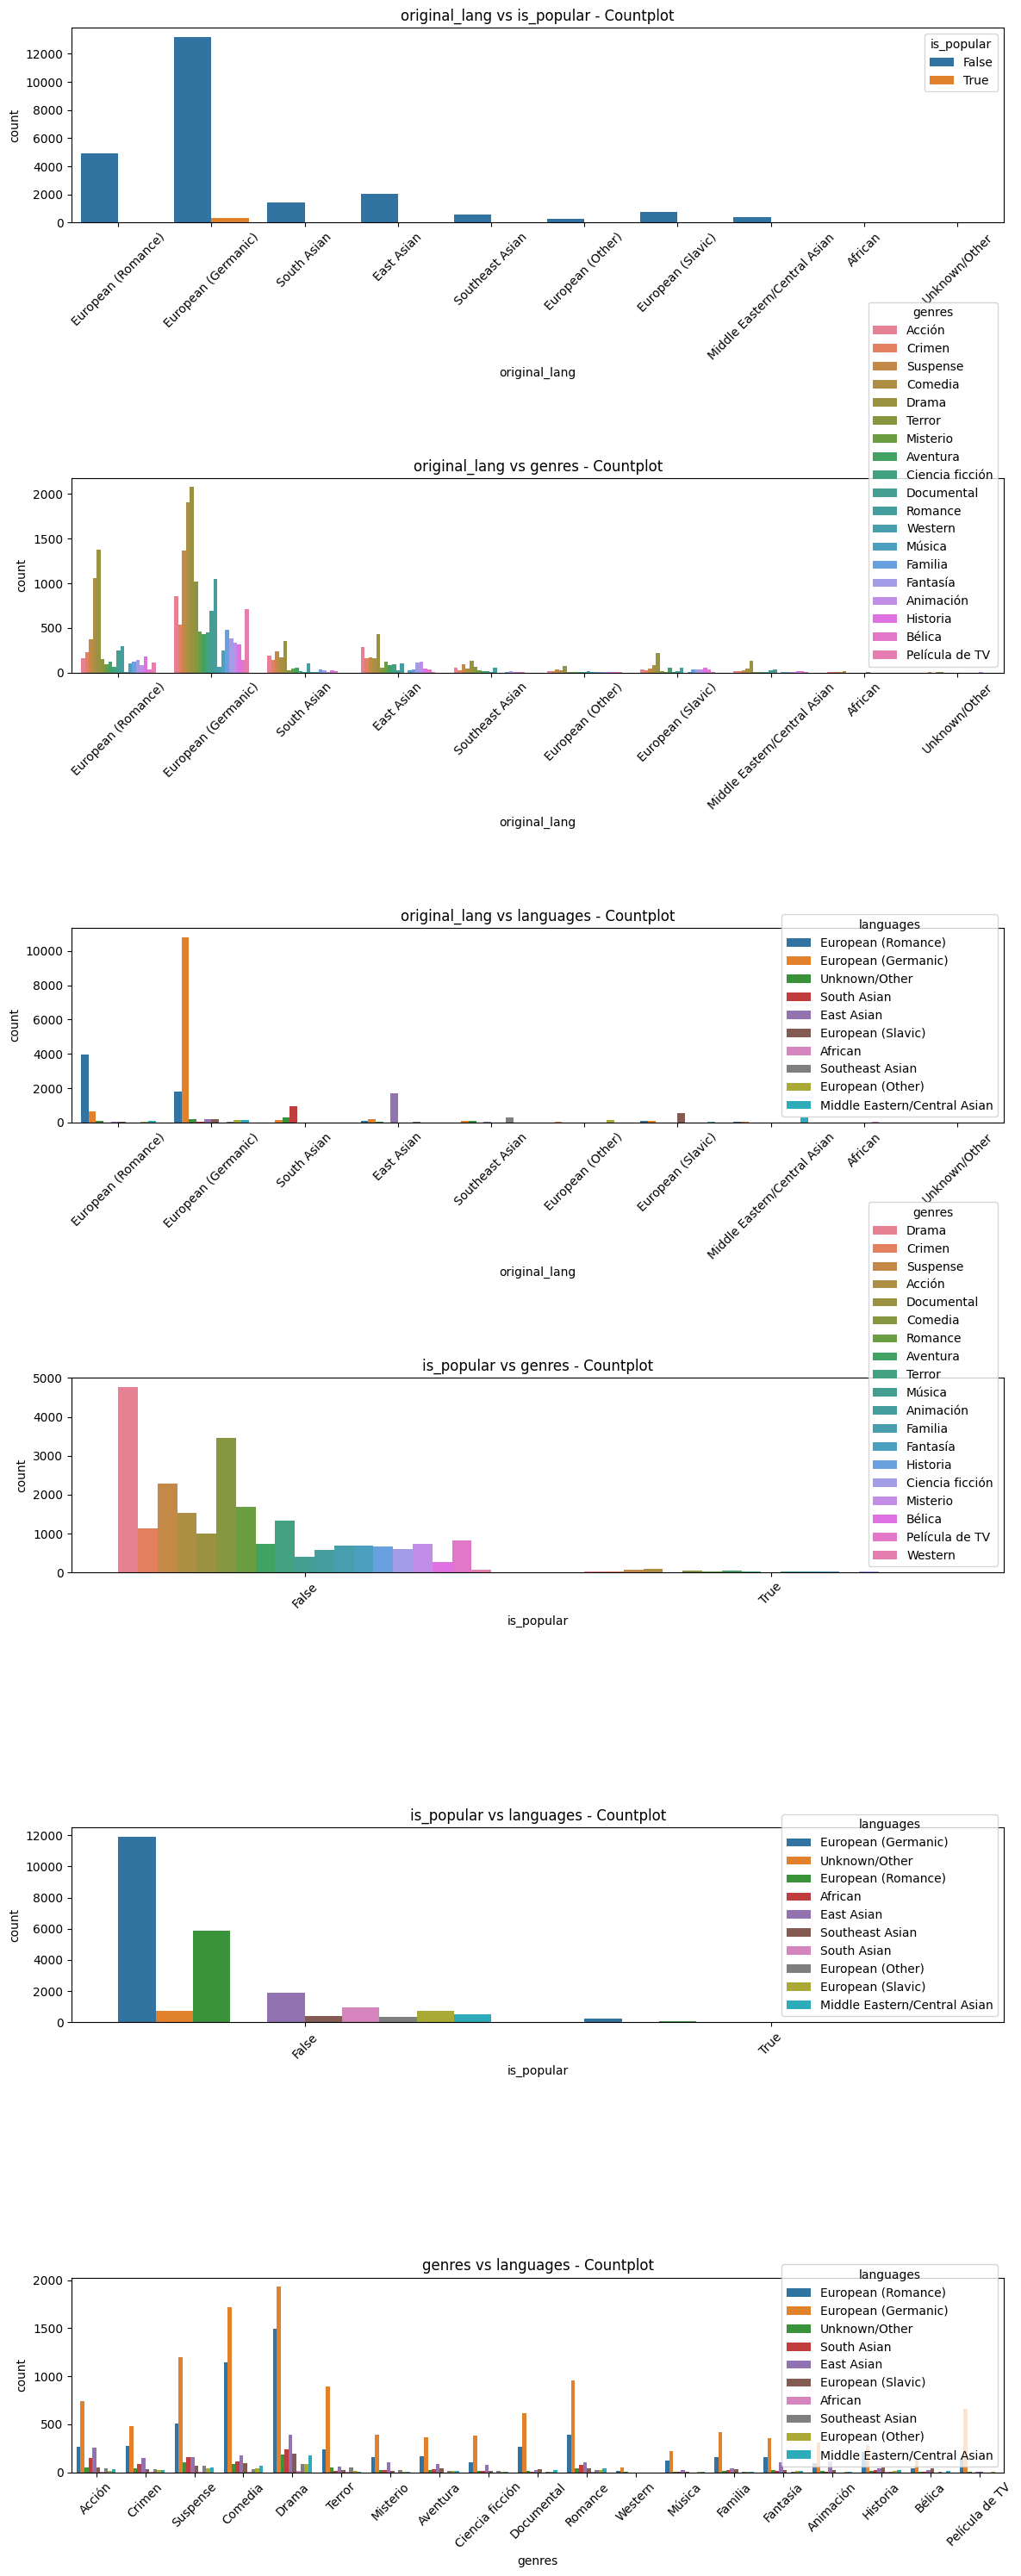

In [23]:
cat_combinations = list(combinations(df_cat.columns, 2))
num_plots = len(cat_combinations)

fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(12, 5 * max(num_plots, 1)))

for i, (col1, col2) in enumerate(cat_combinations):
    sns.countplot(data=df_cat, x=col1, hue=col2, ax=axes[i])
    axes[i].set_title(f"{col1} vs {col2} - Countplot")
    axes[i].tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

## Findings
1. All popular films have Europian (Germanic) language, my guess: English.

In [24]:
chi2_results = list()

for feat1, feat2 in combinations(df_cat.columns, 2):
    contingency_table = pd.crosstab(df_cat[feat1], df_cat[feat2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results.append({
        'Variable 1': feat1,
        'Variable 2': feat2,
        'Chi2 Statistic': chi2,
        'P-value': p,
        'Degrees of Freedom': dof
    })
df_chi2 = DataFrame(chi2_results)

In [25]:
alpha: float = 0.05  # significance level

df_chi2["Reject Null Hypothesis"] = df_chi2["P-value"] <= alpha

In [26]:
df_chi2

,Variable 1,Variable 2,Chi2 Statistic,P-value,Degrees of Freedom,Reject Null Hypothesis
0,original_lang,is_popular,120.026225,1.319751e-21,9,True
1,original_lang,genres,3010.202715,0.000000e+00,162,True
2,original_lang,languages,83608.620462,0.000000e+00,81,True
3,is_popular,genres,328.014590,8.081630e-59,18,True
4,is_popular,languages,19.635283,2.030155e-02,9,True
5,genres,languages,2179.457166,0.000000e+00,162,True


## Findings
1. For all features we could reject the null value hypotesis with an alpha of 0.05, implying that the distributions of the features are releted / dependant on each other for all features pairs.
2. We should definetly take this (categorical features relations) into account for a modeling step, will have to be extra carefull of not choosing a model that assume independece of predictors, or be mindfull of the features we use.

# Caregorical vs numerical

In [27]:
cat_cols = ['original_lang', 'is_popular', 'genres', 'languages']
num_cols = ['popularity', 'vote_average', 'vote_count', 'runtime', 'budget', 'revenue']

In [28]:
cat_num_cols: list[str] = [
    *cat_cols,
    *num_cols
]

df_cat_num = df[cat_num_cols]

In [29]:
df_cat_num.sample(5)

,original_lang,is_popular,genres,languages,popularity,vote_average,vote_count,runtime,budget,revenue
8928,European (Germanic),False,Película de TV,European (Romance),0.7659,8.300,12,88,0,0
16492,European (Romance),False,Drama,East Asian,0.6863,4.800,28,80,0,0
21498,European (Germanic),False,Suspense,European (Germanic),0.4529,5.900,10,99,0,0
22618,European (Germanic),False,Acción,European (Germanic),2.3235,7.346,790,78,0,0
18173,European (Germanic),False,Drama,European (Germanic),0.5098,5.800,18,111,0,0


In [30]:
combinations = [(cat, num) for cat in cat_cols for num in num_cols]

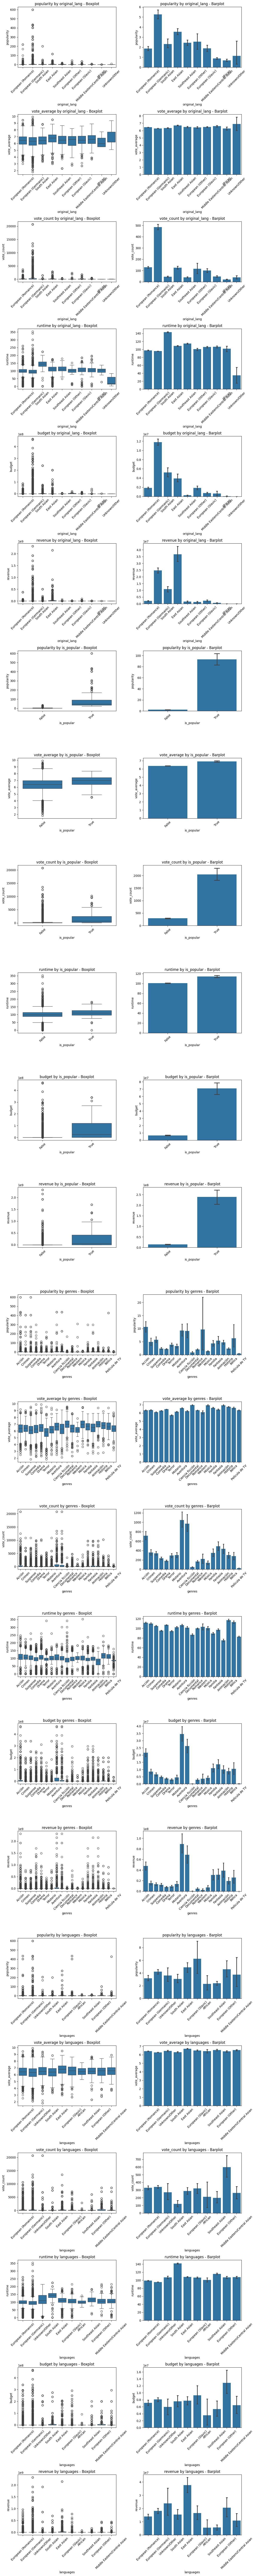

In [31]:
num_plots = len(combinations)

fig, axes = plt.subplots(nrows=num_plots, ncols=2, figsize=(12, 5 * num_plots))

for i, (cat, num) in enumerate(combinations):
    sns.boxplot(data=df_cat_num, x=cat, y=num, ax=axes[i][0])
    axes[i][0].set_title(f"{num} by {cat} - Boxplot")
    axes[i][0].tick_params(axis="x", rotation=45)

    sns.barplot(data=df_cat_num, x=cat, y=num, errorbar="ci", capsize=0.1, ax=axes[i][1])
    axes[i][1].set_title(f"{num} by {cat} - Barplot")
    axes[i][1].tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

In [32]:
kruskal_results = list()

for cat_col, num_col in combinations:
    unique_cat = df_cat_num[cat_col].dropna().unique()
    data_by_category = [df_cat_num[num_col][df_cat_num[cat_col] == category].dropna() for category in unique_cat]
    h_statistic, p_value = kruskal(*data_by_category)
    kruskal_results.append({
        'Categorical Variable': cat_col,
        'Numerical Variable': num_col,
        'Kruskal-Wallis H Statistic': h_statistic,
        'P-value': p_value
    })

df_kruskal = DataFrame(kruskal_results)

In [33]:
alpha: float = 0.05
df_kruskal["Reject Null Hypothesis (alpha=0.05)"] = df_kruskal["P-value"] <= alpha

In [34]:
df_kruskal

,Categorical Variable,Numerical Variable,Kruskal-Wallis H Statistic,P-value,Reject Null Hypothesis (alpha=0.05)
0,original_lang,popularity,1430.401130,2.086037e-302,True
1,original_lang,vote_average,519.988902,3.009109e-106,True
2,original_lang,vote_count,965.593425,4.515814e-202,True
3,original_lang,runtime,4494.940518,0.000000e+00,True
4,original_lang,budget,336.773070,4.037899e-67,True
5,original_lang,revenue,559.497865,1.023471e-114,True
6,is_popular,popularity,1268.559360,7.687373e-278,True
7,is_popular,vote_average,160.345377,9.510165e-37,True
8,is_popular,vote_count,600.339489,1.412400e-132,True
9,is_popular,runtime,128.016896,1.112915e-29,True


## Regarding Kruskal-Wallis H test
We've just applied Kruskal-Wallis H test for each pair of categorical and numerical variables to determine wether a relation between said variables exists. Kruskal does this by applying two kinds of hypotesis to the data:
- Null Hypotesis: This hypotesis tests wheter variation of the numerical variable exists across all categorical groups, if it doesn't (there's no variation of the numerical feature across the different categorical groups) we say the null hypotesis was met.
- Alternative Hypothesis: Means that significant difference of the numerical variable does exist across al categorical groups.

## Findings
1. For all categorical and numerical pairs in the dataset a statistically significant relationship exists.
2. We should definetly take this (numerical and categorical features relations) into account for a modeling step, will have to be extra carefull of not choosing a model that assume independece of predictors, or be mindfull of the features we use.